
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 1 - The Reinforcement Learning Framework</b></center></h2>

<br>
<center><font size="3">This notebook is a part of teaching material for ELEC-E8125</font></center>
<center><font size="3">Sep 4, 2023 - Nov 30, 2023</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Cartpole</a>
* <a href='#3.'> 3. Reacher</a>
* <a href='#4.'> 4. Submitting </a>
* <a href='#4.1'> 4.1 Feedback </a>
* <a href='#5.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Learning (10 points)</a>\
<a href='#T2'><b>Student Task 2.</b> Investigating Training Performance (10 points) </a>\
<a href='#Q2'><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </a>\
<a href='#Q3'><b>Student Question 2.2</b> Stochasticity (10 points) </a>\
<a href='#T3'><b>Student Task 3.</b> Reward Functions (20 points) </a>\
<a href='#T4'><b>Student Task 4.</b> Visualizing Behavior (10 points) </a>\
<a href='#Q4'><b>Student Question 4.1</b> Achieved Peformance (5 points)\
<a href='#Q5'><b>Student Question 4.2</b> Analysis of Behaviour (10 points)</a>
    
**Total Points:** 100

# 1. Introduction <a id='1.'></a>
In this exercise we will take a first look at a reinforcement learning environment, its components and modify the reward function of a simple agent.

In this notebook two environments are used: Cartpole and Reacher. The cartpole environment is taken from [OpenAI's Gym library](https://www.gymlibrary.dev/). The reacher environment is custom made (and defined in ```reacher.py```) but utilizes the Gym API.

## 1.1 Learning Objectives: <a id='1.1'></a>
- To become familiar with assignment structure and the agent-environment relationshp
- To understand the effects of stochasticity
- To understand and explore the effects of task definition

## 1.2 Code Structure & Files <a id='1.2'></a>

The ```train.py``` file instantiates the environment and the RL agent that acts in it. The ```agent.py``` file contains the implementation of a simple reinforcement learning agent; for the sake of this exercise, you can assume it to be a black box (you don’t need to understand how it works, although you are encouraged to study it in more detail). You don’t have to edit any other file other than ```ex1.ipynb``` to complete this exercise.
```
├───cfg                  # Config files for environments e.g. define the maximum number of steps in an episode.
├───imgs                 # Images used in notebook
├───results 
│   ├───logging          # Contains logged data
│   ├───model            # Contains the policies learned
│   └───video            # Contains videos for each environment
│       └───CartPole-v0
│       │  └───test      # Videos saved during testing
│       │  └───train     # Videos saved during training
│       └───SpinningReacher-v0
│           └───test
│           └───train
├───wandb                # Data saved for wandb
│   ex1.ipynb            # Main assignment file containing tasks <---------
│   feedback.ipynb       # Please give feedback in here
│   README.ipynb         # This file
│   agent.py             # Contains functions that govern the policy
│   reacher.py           # Defines the reacher environment
│   train.py             # Contains training and testing functions
│   utils.py             # Contains useful functions 
```

Please consult ```README.md``` for more details the assignments.

The assignments use wandb to visualize data. You need to set Wandb up and login using the command below.

In [36]:
!pip install wandb
! wandb login 6cae6f8a005a6a677e9f79c25bc9a6f2551e2843 # Insert API key here. You can get your API key from https://wandb.ai/authorize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.3 MB/s eta 0:00:0000:01
wandb: Appending key for api.wandb.ai to your netrc file: /home/encinal1/.netrc


In [37]:
from pathlib import Path # to find directory
work_dir = Path().cwd()/'results'
import os
os.environ['WANDB_NOTEBOOK_NAME'] = str(Path().cwd()/'ex1.ipynb') # Detects notebook for wandb

import train as t # for training
import utils as u # helper functions

import numpy as np # The numpy library can be used for math functions
import torch # Used to manage policy and learning
from IPython.display import Video, display # to display videos

# 2. Cartpole <a id='2.'></a>

The Cartpole environment consists of a cart and a pole mounted on top of it, as shown in Figure 1. The cart can move either to the left or to the right. The goal is to balance the pole in a vertical position in order to prevent it from falling down. The cart should also stay within limited distance from the center (trying to move outside screen boundaries is considered a failure).

<figure>
<img src="imgs/cartpole.png" width="400px">
<figcaption style="text-align: center"> Figure 1: The Cartpole environment  </figcaption>
</figure>

The state and the observation are four element vectors:

$$
o=s=\left(\begin{array}{c}
x \\
\dot{x} \\
\theta \\
\dot{\theta}
\end{array}\right) \text {, }
$$

where $x$ is the position of the cart, $\dot{x}$ is its velocity, $\theta$ is the angle of the pole w.r.t. the vertical axis, and $\dot{\theta}$ is the angular velocity of the pole.

In the standard formulation, a reward of 1 is given for every timestep the pole remains balanced. Upon failing (the pole falls) or completing the task, an episode is finished.

The training script will record videos of the agent’s learning progress during training, and the recorded videos are saved to ```results/video/CartPole-v0/train```. By default, the training information is saved to ```results/logging/CartPole-v0_logging.pkl``` as well as on cloud via wandb. When the training is finished, the models are saved to ```results/model/Cartpole-v0_params.pt```. The models can be tested by setting ```testing=true``` in ```cfg_args```, and if the models are saved to a different path, you can use ```model_path=<YOUR MODEL PATH>``` to indicate it. Videos of the agent’s behaviour during testing are saved to ```results/video/CartPole-v0/test```.

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Training a Model for Simple Cartpole Environment (10 points) </h3> 

This task requires you to train a model for the cartpole environment with 100 timesteps per episode and then report the training plot using 'Weights \& Biases'. Then test the model for 1000 timesteps and report average reward. To do this, you can simply run the code in the cells below. 

To see a full list of options that can be passed through ```cfg_args``` consult the configuation file found in ```cfg/```.

- **1st:** setup 'Weights \& Biases', check the README for help. 
- **2nd:** Run training over 100 steps per episode by using ```t.train``` function. See the cell below. 
- **3rd:** Export the training plot ```episodesep_reward``` from wandb (see ```README.md```) and attach below.
- **4th:** Run testing over 1000 steps by using ```t.test``` function. See the cell below. See the cell below. Notice ```max_episode_steps``` parameter. 
- **5th:** Report the average reward after testing the model.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [29]:
t.train(cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
        cfg_args=dict(seed=1, max_episode_steps=100)) # < 5 mins

Numpy/Torch/Random Seed:  1


ep_reward,▁▁▂▁▂▁▁▁▃▁▂▂▁█▃▁▂█████████████████▃█████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▁▁▂▁▂▁▁▁▃▁▂▂▁█▃▁▂█████████████████▃█████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 1, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 28.0 (28 timesteps)
Episode 1 finished. Total reward: 34.0 (34 timesteps)
Episode 2 finished. Total reward: 17.0 (17 timesteps)
Episode 3 finished. Total reward: 11.0 (11 timesteps)
Episode 4 finished. Total reward: 34.0 (34 timesteps)
Episode 5 finished. Total reward: 18.0 (18 timesteps)
Episode 6 finished. Total reward: 76.0 (76 timesteps)
Episode 7 finished. Total reward: 12.0 (12 timesteps)
Episode 8 finished. Total reward: 10.0 (10 timesteps)
Episode 9 finished. Total reward: 41.0 (41 timesteps)
Episode 10 finished. Total reward: 33.0 (33 

<figure style="text-align: center;">
<img src="imgs/plot1_ep_reward.png" width="400px">
<figcaption style="text-align: center"> Figure 1: episodes ep_reward </figcaption>
</figure>

The command below will evaluate the trained model in 10 episodes and report the average reward (and episode length) for these 10 episodes.

In [30]:
t.test(episodes=10, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

Numpy/Torch/Random Seed:  501
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 196.0 seed: 88
Test ep reward: 160.0 seed: 672
Test ep reward: 163.0 seed: 680
Test ep reward: 153.0 seed: 592
Test ep reward: 180.0 seed: 481
Test ep reward: 189.0 seed: 78
Test ep reward: 1046.0 seed: 735
Test ep reward: 338.0 seed: 852
Test ep reward: 169.0 seed: 694
Test ep reward: 163.0 seed: 965
Average test reward: 275.7 episode length: 275.7


The average reward after testing the model is 275.7 

The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [31]:
from IPython.display import Video, display, HTML

# Train Result
video_dir = work_dir/'video'/'CartPole-v1'/'train'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith("-50.mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #FF5733;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

test/ ex1-episode-50.mp4


In [32]:
# Test Result

video_dir = work_dir/'video'/'CartPole-v1'/'test'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith("-9.mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #5733FF;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)

test/ ex1-episode-9.mp4


<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Learning (10 points) </h3> 

Test the trained model from Task 1 five times with different random seeds. Did the same model, trained to balance for 100 timesteps, learn to always balance the pole for 1000 timesteps? Why/why not?
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [36]:
t.test(episodes=5, 
       cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
       cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))

# Test Result
video_dir = work_dir/'video'/'CartPole-v1'/'test'

# List all MP4 files in the directory
mp4_files = [file for file in os.listdir(video_dir) if file.endswith(".mp4")]
frame_colors = ['#FF5733', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF', '#FF33FF']
# Display each MP4 file
for i, mp4_file in enumerate(mp4_files):
    video_path = os.path.join(video_dir, mp4_file)
    video = Video(video_path, embed=True, html_attributes="loop autoplay", width=200, height=100)
    frame_color = frame_colors[i % len(frame_colors)]
    video_frame = HTML(f'<div style="width: 200px; height: 100px;; border: 1px solid #5733FF;">{video._repr_html_()}</div>')
    print("test/",mp4_file)
    display(video_frame)


Numpy/Torch/Random Seed:  449
Loading model from /notebooks/rl2023/ex1/results/model/CartPole-v1_params.pt ...
Testing...
Test ep reward: 230.0 seed: 700
Test ep reward: 228.0 seed: 13
Test ep reward: 377.0 seed: 262
Test ep reward: 186.0 seed: 399
Test ep reward: 475.0 seed: 42
Average test reward: 299.2 episode length: 299.2


It didn't learn to always balance. Many environments, including the CartPole task, have inherent stochasticity. Randomness in the environment can cause the same policy to have different outcomes in different runs.

<a id='T2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 2.</b> Investigating Training Performance (10 points) </h3> 

Repeat the experiment in Task 1 five times, each time training the model from scratch with 100 timesteps and testing it for 1000 timesteps. Use a different seed number for each training/testing cycle. You can use the box below to write a small script to do this. Use the result textbox below to report the average test reward for each repeat. 
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [44]:
import random

for iteration in range(5):
    # Generate a random seed value for this iteration
    s = random.randint(1, 100)

    t.train(cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
            cfg_args=dict(seed=s, max_episode_steps=100)) # < 5 mins

    t.test(episodes=10, 
           cfg_path=Path().cwd()/'cfg'/'cartpole_v1.yaml', 
           cfg_args=dict(testing=True, seed=None, max_episode_steps=1000, use_wandb=False))



Numpy/Torch/Random Seed:  5


ep_reward,▂▂▂▂▃▄▁▂▂▂▂▂▁▃▄▃▅▃▂██▄█▄████████████████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▂▂▂▂▃▄▁▂▂▂▂▂▁▃▄▃▅▃▂██▄█▄████████████████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 5, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 18.0 (18 timesteps)
Episode 1 finished. Total reward: 16.0 (16 timesteps)
Episode 2 finished. Total reward: 23.0 (23 timesteps)
Episode 3 finished. Total reward: 18.0 (18 timesteps)
Episode 4 finished. Total reward: 36.0 (36 timesteps)
Episode 5 finished. Total reward: 16.0 (16 timesteps)
Episode 6 finished. Total reward: 20.0 (20 timesteps)
Episode 7 finished. Total reward: 14.0 (14 timesteps)
Episode 8 finished. Total reward: 31.0 (31 timesteps)
Episode 9 finished. Total reward: 19.0 (19 timesteps)
Episode 10 finished. Total reward: 15.0 (15 

ep_reward,▁▂▃▂▁▂▁▁▂▁▃▃▂▂▄▃▂▄▂████████████████████▂
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
timesteps,▁▂▃▂▁▂▁▁▂▁▃▃▂▂▄▃▂▄▂████████████████████▂
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 76, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 13.0 (13 timesteps)
Episode 1 finished. Total reward: 19.0 (19 timesteps)
Episode 2 finished. Total reward: 15.0 (15 timesteps)
Episode 3 finished. Total reward: 23.0 (23 timesteps)
Episode 4 finished. Total reward: 36.0 (36 timesteps)
Episode 5 finished. Total reward: 26.0 (26 timesteps)
Episode 6 finished. Total reward: 11.0 (11 timesteps)
Episode 7 finished. Total reward: 54.0 (54 timesteps)
Episode 8 finished. Total reward: 17.0 (17 timesteps)
Episode 9 finished. Total reward: 21.0 (21 timesteps)
Episode 10 finished. Total reward: 11.0 (11

ep_reward,▂▄▁▁▁▂▁▂▂▂▁▂▁▁▃▄▁▅▁█▂▇▆█████████████████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
timesteps,▂▄▁▁▁▂▁▂▂▂▁▂▁▁▃▄▁▅▁█▂▇▆█████████████████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 49, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 20.0 (20 timesteps)
Episode 1 finished. Total reward: 15.0 (15 timesteps)
Episode 2 finished. Total reward: 19.0 (19 timesteps)
Episode 3 finished. Total reward: 34.0 (34 timesteps)
Episode 4 finished. Total reward: 42.0 (42 timesteps)
Episode 5 finished. Total reward: 15.0 (15 timesteps)
Episode 6 finished. Total reward: 22.0 (22 timesteps)
Episode 7 finished. Total reward: 11.0 (11 timesteps)
Episode 8 finished. Total reward: 36.0 (36 timesteps)
Episode 9 finished. Total reward: 28.0 (28 timesteps)
Episode 10 finished. Total reward: 17.0 (17

ep_reward,▃▂▁▂▂▃▁▁▁▃▃▅▁▄▁▃▃▄▂▇█▃▃█████████▆███▃█▂█
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
timesteps,▃▂▁▂▂▃▁▁▁▃▃▅▁▄▁▃▃▄▂▇█▃▃█████████▆███▃█▂█
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 73, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 15.0 (15 timesteps)
Episode 1 finished. Total reward: 14.0 (14 timesteps)
Episode 2 finished. Total reward: 21.0 (21 timesteps)
Episode 3 finished. Total reward: 17.0 (17 timesteps)
Episode 4 finished. Total reward: 48.0 (48 timesteps)
Episode 5 finished. Total reward: 46.0 (46 timesteps)
Episode 6 finished. Total reward: 36.0 (36 timesteps)
Episode 7 finished. Total reward: 27.0 (27 timesteps)
Episode 8 finished. Total reward: 15.0 (15 timesteps)
Episode 9 finished. Total reward: 19.0 (19 timesteps)
Episode 10 finished. Total reward: 28.0 (28

ep_reward,▂▂▁▃▁▂▁▂▂▃▂▂▁▁▅▂▂▅▁▆█▃██████████████████
episodes,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
num_updates,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
timesteps,▂▂▁▃▁▂▁▂▂▃▂▂▁▁▅▂▂▅▁▆█▃██████████████████
ep_reward,100.0
episodes,500
num_updates,0
timesteps,100


Configuration Settings: {'exp_name': 'ex1', 'seed': 50, 'env_name': 'CartPole-v1', 'max_episode_steps': 100, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': True, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 4
Action space dimensions: 2

Episode 0 finished. Total reward: 17.0 (17 timesteps)
Episode 1 finished. Total reward: 18.0 (18 timesteps)
Episode 2 finished. Total reward: 13.0 (13 timesteps)
Episode 3 finished. Total reward: 34.0 (34 timesteps)
Episode 4 finished. Total reward: 16.0 (16 timesteps)
Episode 5 finished. Total reward: 33.0 (33 timesteps)
Episode 6 finished. Total reward: 11.0 (11 timesteps)
Episode 7 finished. Total reward: 11.0 (11 timesteps)
Episode 8 finished. Total reward: 13.0 (13 timesteps)
Episode 9 finished. Total reward: 16.0 (16 timesteps)
Episode 10 finished. Total reward: 51.0 (51

Cycle 1: Average test reward: 115.6 
Cycle 2: Average test reward: 137.0
Cycle 3: Average test reward: 139.8  
Cycle 4: Average test reward: 171.6  
Cycle 5: Average test reward: 128.7  

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.1</b> Analysis of Training Performance (15 points) </h3> 

Are the behavior and performance of the trained models the same every time? Why/why not? Analyze the causes briefly.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


No, the behavior and performance of trained models vary when changing the seed due to random initialization, stochastic environments and exploration strategies.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 2.2</b> Stochasticity (10 points) </h3> 

What are the implications of this stochasticity, when it comes to comparing reinforcement learning algorithms to each other? Please explain.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


Stochasticity in reinforcement learning makes algorithm comparisons complex due to performance variability, sample efficiency differences, and the need for statistical rigor and reproducibility in evaluations.

# Reacher <a id='3.'></a>

Now we will focus on designing a reward function for a different environment, the Reacher environment, where a two-joint manipulator needs to reach a goal (see Figure 2).

<figure>
<img src="imgs/reacher.png" width="200px">
<figcaption style="text-align: center"> Figure 2: The Reacher environment  </figcaption>
</figure>

The Cartesian ($x$, $y$) position of the end-effector of the manipulator can be determined following the equation:

$$
 x = L_1 \sin(\theta_0)+L_2 \sin(\theta_0+\theta_1)\\
 y = -L_1 \cos(\theta_0)-L_2 \cos(\theta_0+\theta_1)
$$

where $L1 = 1$, $L2 = 1$ are the lengths, and $\theta_0$, $\theta_1$ the joint angles of the first and second links respectively. The state (and observation) in this environment is the two element vector:

$$
o=s=\left(\begin{array}{c}
\theta_0 \\
\theta_1 \\
\end{array}\right) \text {, }
$$

The action space now consists of 5 "options"; 4 correspond rotating the first/second joint left/right, and the final one performs no motion at all (the configuration doesn’t change). The episode terminates when the agent reaches the target position, marked in red. Now, let us design a custom reward function and use it for training the RL agent.

<a id='T3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 3.</b> Reward Functions (20 points) </h3> 

Below two classes are shown that modify the reward function of the reacher function provided in ```reacher.py```. Edit the function ```get_reward``` _below_ (not in ```reacher.py```) in both classes. For each class, write a reward function to incentivise the agent to learn the following behaviors:

Class 1) ```SpinningReacherEnv```: Keep the manipulator rotating clockwise continuously (w.r.t. angle θ_0). You can use a lower number of training episodes for this, e.g. train(cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200), overrides=['env=reacher_v1'])

Class 2) ```TargetReacherEnv```: Reach the goal point located in x = [1.0,1.0] (marked in red). Use at least 500 training episodes.
    
Train one model for each behavior. 

**Hint:** Use the observation vector to get the quantities required to compute the new reward (such as the position of the manipulator). You can get the Cartesian position of the end-effector with ```self.get_cartesian_pos(state)```.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [65]:
from reacher import ReacherEnv
from typing import Optional
import math
from gymnasium.envs.registration import register

class SpinningReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)
        
    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the first reward function
        ########## Your code starts here ##########
        
        #print("action", action)        
        #print("angle 0 difference", next_state[0]-prev_state[0])
        #print("angle 1 difference", next_state[1]-prev_state[1])
        
        #moving right angle 0
        if action==1:
            #minimazing angles distance to be continuous
            return  math.pi+(next_state[0]-prev_state[0])
       
        #moving right angle 1
        elif action==3:
            #minimazing angles distance to be continuous
            return math.pi+(next_state[1]-prev_state[1])
        
        #no move
        elif action==4:
            return 0
        
        #moving left
        else:
            return -1
        
        ########## Your codes end here ########## 
        
    
register("SpinningReacher-v0",
        entry_point="%s:SpinningReacherEnv"%__name__,
        max_episode_steps=200)

class TargetReacherEnv(ReacherEnv):
    def __init__(self, render_mode: Optional[str] = None, max_episode_steps=200):
        super().__init__(render_mode=render_mode, max_episode_steps=max_episode_steps)
        
    def get_reward(self, prev_state, action, next_state):
        # TODO: Task 3: Implement and test the second reward function
        ########## Your code starts here ##########
        
        #no move
        if action==4:
            return 0
        else:
            prev_pos=self.get_cartesian_pos(prev_state)
            next_pos=self.get_cartesian_pos(next_state)
            
            #calculate the distance to the goal point [1,1] and see which one is closer
            distance_prev = math.sqrt((self.goal[0] - prev_pos[0])**2 + (self.goal[1]  - prev_pos[1])**2)
            distance_next = math.sqrt((self.goal[0] - next_pos[0])**2 + (self.goal[1]  - next_pos[1])**2)
            
            #the reward will be negative if the distance to the point has increased
            return distance_prev-distance_next
       
        ########## Your codes end here ########## 
        
register("TargetReacher-v0",
        entry_point="%s:TargetReacherEnv"%__name__,
        max_episode_steps=200)

/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment SpinningReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/software/lib/python3.10/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment TargetReacher-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [66]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='SpinningReacher-v0', train_episodes=200)) # < 5 mins

Numpy/Torch/Random Seed:  522


AttributeError: module 'wandb' has no attribute 'init'

In [40]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='SpinningReacher-v0', testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  620
Loading model from /notebooks/rl2023/ex1/results/model/SpinningReacher-v0_params.pt ...
Testing...


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/SpinningReacher-v0/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test ep reward: 588.3179642354131 seed: 164
Test ep reward: 588.3179639075876 seed: 476
Test ep reward: 588.3179607038379 seed: 545
Test ep reward: 588.3179647718549 seed: 805
Test ep reward: 588.317957202065 seed: 400
Test ep reward: 588.3179617618204 seed: 11
Test ep reward: 588.3179342542768 seed: 50
Test ep reward: 588.317945176828 seed: 341
Test ep reward: 588.3179487680078 seed: 26
Test ep reward: 588.3179320042015 seed: 146
Average test reward: 588.3179532785894 episode length: 200.0


The agent acting in the environment can be seen using the following command. Change the ```path``` to pick the episode you want to visualize. Bear in mind by default video saving for training is taken every 50 episodes.

In [43]:
Video(work_dir/'video'/'SpinningReacher-v0'/'test'/f'ex1-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

In [68]:
t.train(cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
      cfg_args=dict(env_name='TargetReacher-v0', train_episodes=500,use_wandb=False)) # < 5 mins

Numpy/Torch/Random Seed:  600
Configuration Settings: {'exp_name': 'ex1', 'seed': None, 'env_name': 'TargetReacher-v0', 'max_episode_steps': 200, 'train_episodes': 500, 'batch_size': 64, 'min_update_samples': 2000, 'testing': False, 'model_path': 'default', 'save_video': True, 'save_model': True, 'save_logging': True, 'silent': False, 'use_wandb': False, 'run_suffix': 0}
Training device: cpu
Observation space dimensions: 2
Action space dimensions: 5



/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/TargetReacher-v0/train folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Episode 0 finished. Total reward: 0.9008567331615647 (200 timesteps)
Episode 1 finished. Total reward: 1.5543622227751785 (200 timesteps)
Episode 2 finished. Total reward: 2.3569068907098516 (200 timesteps)
Episode 3 finished. Total reward: 0.6750365351546912 (200 timesteps)
Episode 4 finished. Total reward: 0.6600279899916279 (200 timesteps)
Episode 5 finished. Total reward: 0.6724488871951027 (200 timesteps)
Episode 6 finished. Total reward: 0.3775254544215316 (200 timesteps)
Episode 7 finished. Total reward: 0.382156081319482 (200 timesteps)
Episode 8 finished. Total reward: 0.94602023264135 (200 timesteps)
Episode 9 finished. Total reward: 2.4374163759981013 (200 timesteps)
Updating the policy...
Updating finished!
Episode 10 finished. Total reward: 2.929710305858141 (69 timesteps)
Episode 11 finished. Total reward: 2.8984516558214803 (170 timesteps)
Episode 12 finished. Total reward: 3.0593140688722817 (39 timesteps)
Episode 13 finished. Total reward: 1.614337426505898 (200 timest

In [69]:
t.test(episodes=10, cfg_path=Path().cwd()/'cfg'/'reacher_v1.yaml', 
       cfg_args=dict(env_name='TargetReacher-v0', seed=None, testing=True, use_wandb=False))

Numpy/Torch/Random Seed:  375
Loading model from /notebooks/rl2023/ex1/results/model/TargetReacher-v0_params.pt ...
Testing...


/opt/software/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /notebooks/rl2023/ex1/results/video/TargetReacher-v0/test folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Test ep reward: 3.0979755374677436 seed: 484
Test ep reward: 2.986542435778187 seed: 409
Test ep reward: 3.0038277559502142 seed: 995
Test ep reward: 2.9570445158977394 seed: 253
Test ep reward: 2.9454101833834065 seed: 125
Test ep reward: 2.9756830722037995 seed: 690
Test ep reward: 2.9816688364400603 seed: 364
Test ep reward: 2.9979862103021464 seed: 648
Test ep reward: 3.0156943163038394 seed: 786
Test ep reward: 2.963241597417004 seed: 368
Average test reward: 2.9925074461144137 episode length: 24.7


In [70]:
Video(work_dir/'video'/'TargetReacher-v0'/'test'/f'ex1-episode-9.mp4',
      embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control

<a id='T4'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 4.</b> Visualizing Behavior (10 points) </h3> 

Now, let us visualize the reward function for the second behavior (reaching the goal [1,1]). Plot the values of the second reward function from Task 3 and the learned best action as a function of the state (the joint positions). Use the code below as a starting point. After plotting, answer the questions below.
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from agent import Agent, Policy

In [72]:
env_name = "TargetReacher-v0" 
resolution = 101  # Resolution of the policy/reward image

# Load policy from default path to plot
policy_dir = Path().cwd()/'results'/'model'/f'{env_name}_params.pt'

sns.set()

# Create a gym environment
env = gym.make(env_name)

action_space_dim = u.get_space_dim(env.action_space)
observation_space_dim = u.get_space_dim(env.observation_space)
policy = Policy(observation_space_dim, action_space_dim)

if policy_dir:
    policy.load_state_dict(torch.load(policy_dir))
    print("Loading policy from", policy_dir)
else:
    print("Plotting a random policy")

Loading policy from /notebooks/rl2023/ex1/results/model/TargetReacher-v0_params.pt


In [73]:
# Create a grid and initialize arrays to store rewards and actions
npoints = resolution
state_range = np.linspace(-np.pi, np.pi, npoints)
rewards = np.zeros((npoints, npoints))
actions = np.zeros((npoints, npoints), dtype=np.int32)

# Loop through state[0] and state[1]
for i,th1 in enumerate(state_range):
    for j,th2 in enumerate(state_range):
        # Create the state vector from th1, th2
        state = np.array([th1, th2])

        # Query the policy and find the most probable action
        with torch.no_grad():
            action_dist, _ = policy(torch.from_numpy(state).float().unsqueeze(0))
        action_probs = action_dist.probs.numpy()

        # TODO: Task 4: 1. What's the best action, according to the policy?
        # .             2. Compute the reward given state
        ########## Your code starts here ##########
        # Use the action probabilities in the action_probs vector
        # (it's a numpy array)
        
        best_action = np.argmax(action_probs)
        
        if(j<len(state_range)-1 and i<len(state_range)-1):
            
            next_state = np.array([state_range[i+1],state_range[j+1]])
            reward = env.get_reward(state, best_action, next_state)

            # Store the best action and reward in the arrays
            actions[i, j] = best_action
            rewards[i, j] = reward
        
        ########## Your code ends here ##########


/opt/software/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_reward to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_reward` for environment variables or `env.get_wrapper_attr('get_reward')` that will search the reminding wrappers.
  logger.warn(


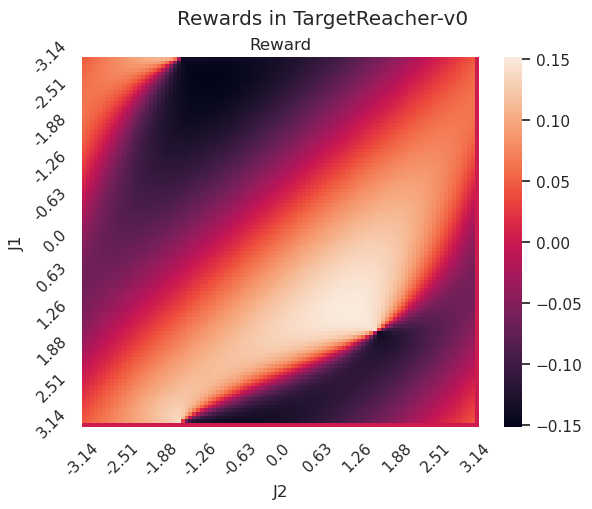

In [74]:
# Create the reward plot
num_ticks = 10
tick_skip = max(1, npoints // num_ticks)
tick_shift = 2*np.pi/npoints/2
tick_points = np.arange(npoints)[::tick_skip] + tick_shift
tick_labels = state_range.round(2)[::tick_skip]

sns.heatmap(rewards)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Reward")
plt.suptitle("Rewards in %s" % env_name)
plt.show()


<figure style="text-align: center;">
<img src="imgs/rewards plot 1.png" width="400px">
<figcaption style="text-align: center"> Figure 1: episodes ep_reward </figcaption>
</figure>

In [1]:
# # Create the policy plot
cmap = sns.color_palette("deep", action_space_dim)
sns.heatmap(actions, cmap=cmap, vmin=0, vmax=action_space_dim-1)
plt.xticks(tick_points, tick_labels, rotation=45)
plt.yticks(tick_points, tick_labels, rotation=45)
colorbar = plt.gca().collections[0].colorbar
ticks = np.array(range(action_space_dim))*((action_space_dim-1)/action_space_dim)+0.5
colorbar.set_ticks(ticks)
if env.spec.id == "Reacher-v1":
    # In Reacher, we can replace 0..4 with more readable labels
    labels = ["J1+", "J1-", "J2+", "J2-", "Stop"]
else:
    labels = list(map(str, range(action_space_dim)))
colorbar.set_ticklabels(labels)
plt.xlabel("J2")
plt.ylabel("J1")
plt.title("Best action")
plt.suptitle("Best action in %s" % env_name)
plt.show()

NameError: name 'sns' is not defined

<figure style="text-align: center;">
<img src="imgs/rewards plot 2.png" width="400px">
<figcaption style="text-align: center"> Figure 1: episodes ep_reward </figcaption>
</figure>

<a id='3.2.1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.1</b> Achieved Performance (5 points) </h3> 

Where are the highest and lowest reward achieved?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


The highest rewards are achieved where we can see the graph is brighter, i.e. at th1=1.88 th2=1.26 and at th1=3.14 th2=-1.88 aprox. 
The lowest rewards are achieved where we can see the graph is darker, i.e. around th1=-1.88 th2=-1.88, th1=3.14 th2=0.00 and th1=1.88 th2=1.88 

<a id='Q5'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 4.2</b> Analysis of Behaviour (10 points) </h3> 

Did the policy learn to reach the goal from every possible state (manipulator configuration) in an optimal way (i.e. with lowest possible number of steps)? Why/why not?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

It seems to learn in an optimal way since it always chooses the best movement to reach the red point.

# 4. Submitting <a id='4.'></a>
Ensure all tasks and questions (in ```ex1.ipynb```) are answered and the relevant plots are recorded in the relevant places. Details about attaching images and figures can be found below. The relevant graphs to be included for this assignment are:
- Task 1, WandB CartPole ```episodesep_reward``` plot
- x2 Task 4 reward plots

Ensure the correct model files are saved:
- results/model/CartPole-v1_params.pt
- results/model/SpinningReacher-v0_params.pt
- results/model/TargetReacher-v0_params.pt

## 4.1 Feedback <a id='4.1'></a>
In order to help the staff of the course as well as the forthcoming students, it would be great if you could
answer feedback questionnaire in ```feedback.ipynb```

Please use the following section to record references.
# References <a id='5.'></a>